In [208]:
import os
from datetime import datetime

import gget

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import arcadia_pycolor as apc

In [123]:
query_cover_thresh = 50 #min % of query covered for a homolog 
perident_thresh= 30 #min % percent identity for a homolog

In [ ]:
genenames = {}
BLAST_results_folder = 'inputs/dRE_BlastResults_2023_06_09/'
for i, filename in enumerate(os.listdir(BLAST_results_folder)):

    ensembl_id = filename.replace('.csv','')
    geneinfo = gget.info(ensembl_id)
    name= geneinfo["primary_gene_name"].values
    genenames.update({ensembl_id:name[0]})
    print(str(i+1) + "/" + str(len(os.listdir(BLAST_results_folder))) + " gene names found")

In [15]:
tax_nodes = pd.read_csv('inputs/NCBI_taxdump_20230612/nodes.dmp', delimiter="|", header=None, quotechar='\t')
tax_div = pd.read_csv('inputs/NCBI_taxdump_20230612/division.dmp', delimiter="|", header=None, quotechar='\t')

In [124]:
BLAST_results_folder = 'inputs/dRE_BlastResults_2023_06_09/'
results_list = []

for filename in os.listdir(BLAST_results_folder):
    filepath = BLAST_results_folder + filename
    BLAST_result = pd.read_csv(filepath)
    
    ensembl_id = filename.replace('.csv','')
    BLAST_result['gene'] = genenames[ensembl_id]


    BLAST_result['Query Cover'] = BLAST_result['Query Cover'].str.rstrip('%').astype('float')
    BLAST_result['Per. Ident'] = BLAST_result['Per. Ident'].str.rstrip('%').astype('float')
    BLAST_result = BLAST_result[
                               (BLAST_result['Per. Ident'] > perident_thresh) & 
                               (BLAST_result['Query Cover'] > query_cover_thresh)
                               ].reset_index(drop=True)

    results_list.append(BLAST_result)

results_df = pd.concat(results_list)

In [125]:
divs = tax_nodes.iloc[:,4]
idarray = tax_nodes.iloc[:,0]
ToLdiv = []

for tid in results_df['Taxid']:
  this_species = divs[idarray.index[idarray == tid]]
  this_div = tax_div.iloc[this_species,2]
  ToLdiv.append(this_div.to_string().split()[1])
results_df["ToLdiv"] = ToLdiv

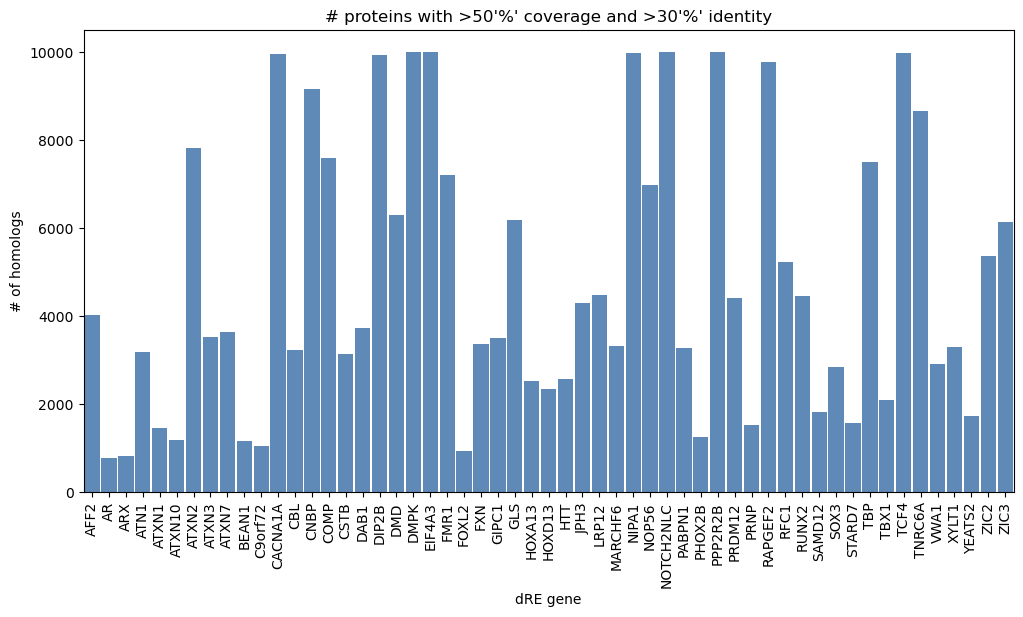

In [160]:
plt.figure(figsize=(12,6))

xlabels = pd.unique(sorted(results_df['gene'])) #alphabetically
# xlabels = results_df['gene'].value_counts().index #by # of homologs

g = sns.countplot(x=sorted(results_df['gene']),
                 order=xlabels,
                 width =0.9,
                 color = 'arcadia:Aegean'
                 )

g.set_xticklabels(xlabels,rotation = 'vertical')

plt.ylabel("# of homologs")
plt.xlabel("dRE gene")
plt.title("# proteins with >" + str(query_cover_thresh) + "'%' coverage and >" + str(perident_thresh) + "'%' identity")

plt.show()

<Figure size 1200x600 with 0 Axes>

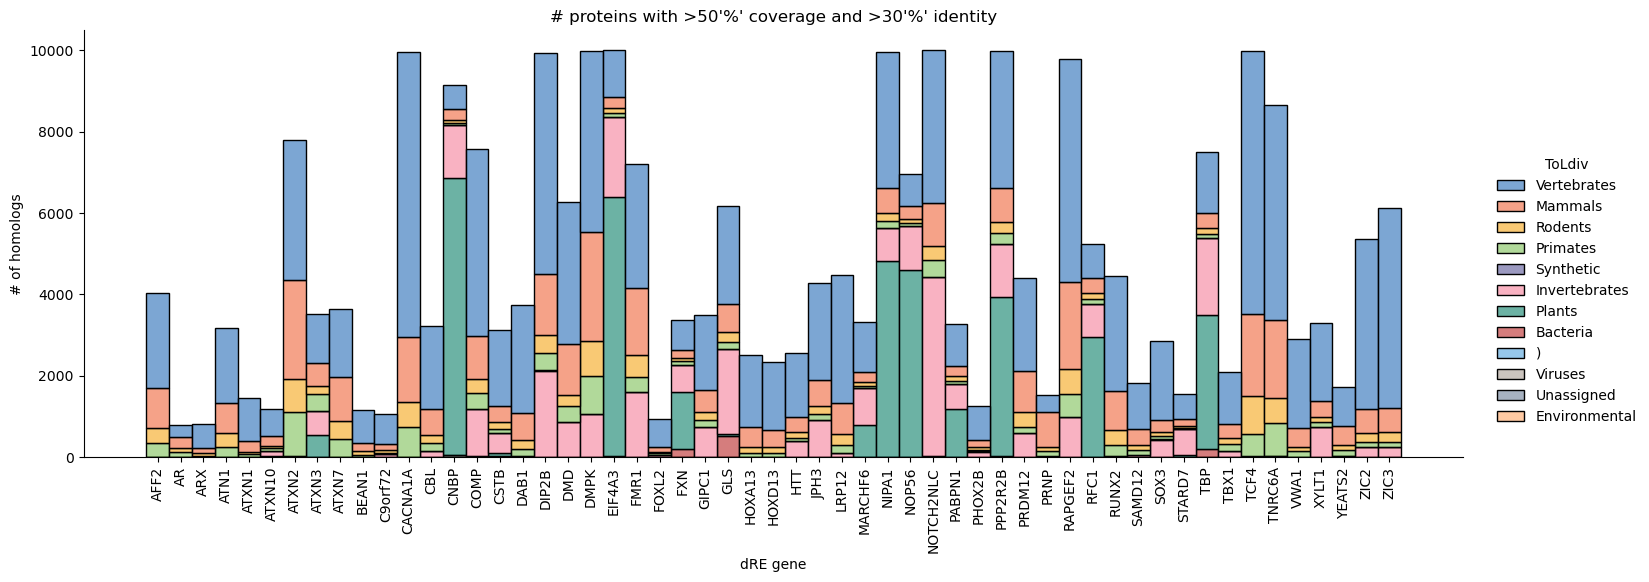

In [161]:
plt.figure(figsize=(12,6))
plot_df = results_df[['gene','ToLdiv']].sort_values(['gene'])

xlabels = pd.unique(plot_df['gene'])

g = sns.displot(plot_df,
                 x='gene', hue='ToLdiv', 
                 multiple='stack',
                 aspect=3, height=5,
                 palette= 'arcadia:AccentOrdered',
                 )

g.set_xticklabels(xlabels,rotation = 90)

plt.ylabel("# of homologs")
plt.xlabel("dRE gene")
plt.title("# proteins with >" + str(query_cover_thresh) + "'%' coverage and >" + str(perident_thresh) + "'%' identity")

plt.show()

Text(0, 0.5, '# of dRE homologs')

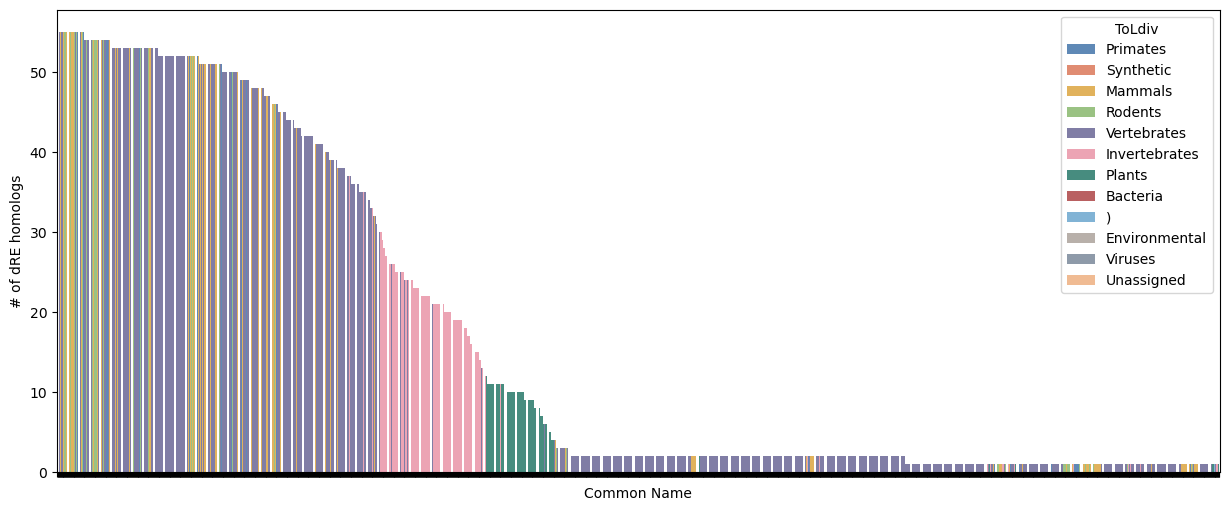

In [185]:
plt.figure(figsize=(15,6))

thisdata = results_df[['Common Name','gene','ToLdiv']].drop_duplicates()
xlabels = thisdata['Common Name'].value_counts().index #by # of homologs

g = sns.countplot(x='Common Name',
                  data=thisdata,
                  order=xlabels,
                  hue = 'ToLdiv',
                  dodge=False,
                  palette= 'arcadia:AccentOrdered'
                  )

g.set_xticklabels([])

# g.set_xticklabels(xlabels,rotation = 'vertical')
# plt.xlim(0,500)
plt.ylabel("# of dRE homologs")
# plt.title("# proteins with >" + str(query_cover_thresh) + "'%' coverage and >" + str(perident_thresh) + "'%' identity")
# plt.ylim(40,55)
# plt.show()

In [184]:
temp = thisdata['Common Name'].value_counts()
print(temp.iloc[0::50])

Common Name
human                        55
golden hamster               55
graceful crag lizard         54
West African lungfish        53
Common wall lizard           53
flier cichlid                52
harbor seal                  51
pikeperch                    50
gyrfalcon                    49
Burton's mouthbrooder        46
black-whiskered vireo        43
Loria's bird-of-paradise     41
wood nuthatch                38
Rufous rock-jumper           34
red-billed oxpecker          26
pitcher-plant mosquito       23
large cabbage white          21
orange sulphur               18
narrow-leaved blue lupine    12
bread wheat                  10
dwarf bunt fungus             8
laver                         3
razor surgeonfish             2
yellowspotted sawtail         2
smallfin lanternfish          2
winged lanternfish            2
fringelip mullet              2
attenuated spider fish        2
derbio                        2
yellow fin mojarra            2
threadfin rockling          

In [335]:
today = datetime.today().strftime('%Y%m%d')

#output homology results_df 
filename = "results/dREhomologs_MR" + today +".csv"
results_df.to_csv(filename)

In [157]:
#output taxid and homologs so Emily can make a tree

thisdata = results_df[['Taxid','gene']].drop_duplicates()
taxid_nhomologs = thisdata[['Taxid']].value_counts().reset_index()

filename = "results/taxid_nhomologs_forEW" + today + ".csv"
taxid_nhomologs.to_csv(filename)